## Linear Regression: Overfitting and Regularization

In this task, we will see examples of how linear models overfit, why this happens, and how to diagnose and control overfitting.

In [201]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

We will work with the __"bikes_rent.csv"__ dataset, which contains calendar information and weather conditions by day, characterizing automated bike rental points, as well as the number of rentals on that day. The last we will predict; thus, we will solve the regression problem.

### Dataset analysis

**Task** Load the dataset using the __pandas.read_csv__ function into the __df__ variable. Print the first 5 lines to make sure the data is read correctly:

In [202]:
df=pd.read_csv('bikes_rent.csv', header=0)
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


For each rental day, the following features are known (as they were indicated in the data source):
* _season_: 1 - spring, 2 - summer, 3 - autumn, 4 - winter
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: 1 to 12
* _holiday_: 0 - no holiday, 1 - holiday
* _weekday_: 0 to 6
* _workingday_: 0 - non-working day, 1 - working day
* _weathersit_: rating of favorable weather from 1 (clear, clear day) to 4 (rain, fog)
* _temp_: temperature in Celsius
* _atemp_: feel temperature in Celsius
* _hum_: humidity
* _windspeed(mph)_: wind speed in miles per hour
* _windspeed(ms)_: wind speed in meters per second
* _cnt_: number of rented bikes (this is the target feature, we will predict it)

So, we have real, binary and nominal (ordinal) features, and all of them can be treated as with real ones. It is also possible to work with nominal features as with real ones, because the order is set on them. Let's look at the graphs, how the target feature depends on the rest

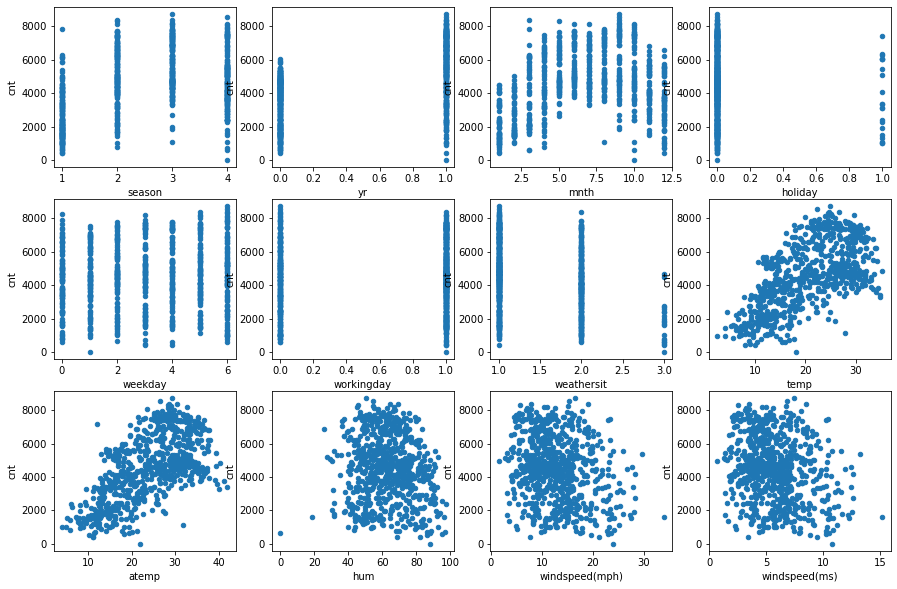

In [203]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
for idx, feature in enumerate(df.columns[:-1]):
    df.plot(feature, "cnt", subplots=True, kind="scatter", ax=axes[idx // 4, idx % 4])

__Block 1. Answer the questions (each 0.5 points):__
1. What is the nature of the dependence of the number of rentals on the month?
    * **answer**: From spring to autumn, the number of rentals is greater than in winter. In spring and autumn a little more than in summer.
1. Indicate one or two features on which the number of rentals most likely depends linearly
    * **answer**: The number of rentals can be linearly dependent on temperature (real and felt)

Let's more rigorously evaluate the level of linear relationship between the features and the target variable. A good measure of a linear relationship between two vectors is the Pearson correlation. In pandas, it can be calculated using two dataframe methods: corr and corrwith. The df.corr method calculates the correlation matrix of all features from the dataframe. The df.corrwith method needs to provide one more dataframe as an argument, and then it will calculate pairwise correlations between features from df and this dataframe.

**Task** Calculate the correlations of all features except the last one with the last one using the corrwith method:

In [204]:
df.iloc[:, 0:12].corr(method='pearson')

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms)
season,1.000000,-0.001844,0.831440,-0.010537,-0.003080,0.012485,0.019211,0.334315,0.342876,0.205445,-0.229046,-0.229046
yr,-0.001844,1.000000,-0.001792,0.007954,-0.005461,-0.002013,-0.048727,0.047604,0.046106,-0.110651,-0.011817,-0.011817
mnth,0.831440,-0.001792,1.000000,0.019191,0.009509,-0.005901,0.043528,0.220205,0.227459,0.222204,-0.207502,-0.207502
holiday,-0.010537,0.007954,0.019191,1.000000,-0.101960,-0.253023,-0.034627,-0.028556,-0.032507,-0.015937,0.006292,0.006292
weekday,-0.003080,-0.005461,0.009509,-0.101960,1.000000,0.035790,0.031087,-0.000170,-0.007537,-0.052232,0.014282,0.014282
workingday,0.012485,-0.002013,-0.005901,-0.253023,0.035790,1.000000,0.061200,0.052660,0.052182,0.024327,-0.018796,-0.018796
weathersit,0.019211,-0.048727,0.043528,-0.034627,0.031087,0.061200,1.000000,-0.120602,-0.121583,0.591045,0.039511,0.039511
temp,0.334315,0.047604,0.220205,-0.028556,-0.000170,0.052660,-0.120602,1.000000,0.991702,0.126963,-0.157944,-0.157944
atemp,0.342876,0.046106,0.227459,-0.032507,-0.007537,0.052182,-0.121583,0.991702,1.000000,0.139988,-0.183643,-0.183643
hum,0.205445,-0.110651,0.222204,-0.015937,-0.052232,0.024327,0.591045,0.126963,0.139988,1.000000,-0.248489,-0.248489


In [205]:
df.iloc[:, 0:12].corrwith(df.iloc[:, 12], axis=0, drop=False, method='pearson')

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64

The sample contains features that correlate with the target, which means that the problem can be solved by linear methods.

The graphs show that some features are similar to each other. Therefore, let's also calculate the correlations between real features.

**Task** Calculate pairwise correlations between features temp, atemp, hum, windspeed(mph), windspeed(ms), and cnt using the corr method:

In [206]:
df.iloc[ :,7:13].corr(method='pearson')

,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


On the diagonals, as expected, there are units. However, there are two more pairs of highly correlated columns in the matrix: temp and atemp (correlated by nature) and two windspeed (because it's just a conversion of one unit to another). Further, we will see that this fact has a negative effect on the training of the linear model.

**Task** let's look at the averages of the features (the mean method) in order to estimate the scale of the features and the share of 1 in binary features.

In [207]:
print(df.iloc[ :,0:12].mean())

season             2.496580
yr                 0.500684
mnth               6.519836
holiday            0.028728
weekday            2.997264
workingday         0.683995
weathersit         1.395349
temp              20.310776
atemp             23.717699
hum               62.789406
windspeed(mph)    12.762576
windspeed(ms)      5.705220
dtype: float64


Features have different scale, which means that for further work it is better for us to normalize the matrix of features-objects.

### 1st Problem: collinear features

So, in our data, one feature duplicates the other, and there are two more very similar ones. Of course, we could immediately remove duplicates, but let's see how the model would have been trained if we had not noticed this problem.

To begin with, let's perform scaling, or standardization of features: subtract its mean from each feature and divide by the standard deviation. This can be done using the scale method.

In addition, you need to mix the sample, this will be required for cross-validation.

In [208]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [209]:
df_shuffled = shuffle(df, random_state=123)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Let's train linear regression on our data and look at the feature weights.

In [210]:
from sklearn.linear_model import LinearRegression
from sklearn import model_selection, datasets, linear_model, metrics

**Task** Create a linear regressor object, train it on all the data, and output the model weights (the weights are stored in the coef_ variable of the regressor class).
You can display pairs (feature name, weight) using the zip function.

In [211]:
linear_regressor = linear_model.LinearRegression()
linear_regressor.fit(X, y)

for i, j in zip(df.columns, linear_regressor.coef_):
    print(i, j)

season 570.8719592302759
yr 1021.9635898212942
mnth -141.30585587144665
holiday -86.75647149074891
weekday 137.2260362759306
workingday 56.390724502512256
weathersit -330.2291534403052
temp 367.46916495965974
atemp 585.5606071882255
hum -145.6111431908375
windspeed(mph) 12457587117893.193
windspeed(ms) -12457587118091.646


We see that the weights for linearly dependent features are significantly greater in modulus than for other features.

To understand why this happened, let's recall the analytical formula by which the weights of the linear model are calculated in the least squares method:

$w = (X^TX)^{-1} X^T y$.

If X has collinear (linearly dependent) columns, the matrix $X^TX$ becomes degenerate and the formula is no longer correct. The more dependent features, the smaller the determinant of this matrix and the worse the approximation $Xw \approx y$. This situation is called the _multicollinearity problem_, you discussed it in the lecture.

With a pair of **temp-atemp** slightly less correlated variables, this did not happen, but in practice it is always worth carefully monitoring the coefficients for similar features.

The __solution__ to the multicollinearity problem is to _regularize_ the linear model. The L1 or L2 weight norm multiplied by the regularization coefficient $\alpha$ is added to the functional to be optimized. In the first case, the method is called Lasso, and in the second, Ridge. More about this is also described in the lecture.

**Task** Train the Ridge and Lasso regressors with default parameters and see if the weight issue is resolved.

In [212]:
from sklearn.linear_model import Lasso, Ridge

In [213]:
lasso_regressor = linear_model.Lasso()
lasso_regressor.fit(X, y)
for i, j in zip(df.columns, lasso_regressor.coef_):
    print(i, j)

season 560.2416160308867
yr 1019.4634940657196
mnth -128.73062703678738
holiday -86.15278133371112
weekday 137.3478939049632
workingday 55.21237064135662
weathersit -332.3698569623486
temp 376.36323620969586
atemp 576.5307935045539
hum -144.12915500348598
windspeed(mph) -197.13968940249575
windspeed(ms) -2.8039823678320867e-08


In [214]:
ridge_regressor = linear_model.Ridge()
ridge_regressor.fit(X, y)
for i, j in zip(df.columns, ridge_regressor.coef_):
    print(i, j)

season 563.0645722520175
yr 1018.9483787875286
mnth -131.87332028247693
holiday -86.74609799709266
weekday 138.00511117871898
workingday 55.903110375064394
weathersit -332.3497884990724
temp 386.4578891919369
atemp 566.3470470600384
hum -145.07132729867288
windspeed(mph) -99.25944108171767
windspeed(ms) -99.25944115441582


### 2nd Problem: uninformative features

Unlike L2-regularization, L1 sets weights to zero for some features. An explanation of this fact is given in one of the lectures of the course.

Let's observe how the weights change as the regularization coefficient $\alpha$ increases (in the lecture, the coefficient at the regularizer could be denoted by a different letter).

**Task** # For each coefficient value from alphas, train a Lasso regressor and write the weights to the appropriate row of the coefs_lasso matrix (remember python's built-in enumerate function), and then train Ridge and write weights to coefs_ridge.

In [215]:
alphas = np.arange(1, 500, 50)
coefs_lasso = np.zeros((alphas.shape[0], X.shape[1])) 
coefs_ridge = np.zeros((alphas.shape[0], X.shape[1]))

for i,a in enumerate(alphas):
    lasso_regressor_a = linear_model.Lasso(alpha=a)
    lasso_regressor_a.fit(X, y)
    coefs_lasso[i]= lasso_regressor_a.coef_
print ('Матрица весов для коэффициентов от 1 до 451, метод L1: \n', coefs_lasso.round(2))

for i,a in enumerate(alphas):
    ridge_regressor_a = linear_model.Ridge(alpha=a)
    ridge_regressor_a.fit(X, y)
    coefs_ridge[i]= ridge_regressor_a.coef_
print ('\n Матрица весов для коэффициентов от 1 до 451, метод L2: \n ', coefs_ridge.round(2))

Матрица весов для коэффициентов от 1 до 451, метод L1: 
 [[ 560.24 1019.46 -128.73  -86.15  137.35   55.21 -332.37  376.36  576.53
  -144.13 -197.14   -0.  ]
 [ 410.97  977.02   -0.    -53.45   91.94   17.54 -318.13  322.83  610.03
   -91.07 -145.07   -0.  ]
 [ 370.08  935.95    0.    -12.16   48.89    0.   -308.81  269.42  632.5
   -27.5   -93.77   -0.  ]
 [ 332.84  891.87    0.     -0.      0.      0.   -279.62  211.05  662.92
    -0.    -50.16   -0.  ]
 [ 298.13  845.65    0.     -0.      0.      0.   -235.57  124.14  725.38
    -0.    -12.65   -0.  ]
 [ 258.93  799.24    0.     -0.      0.      0.   -190.82   72.08  750.36
    -0.     -0.     -0.  ]
 [ 217.43  752.72    0.     -0.      0.      0.   -145.71   37.72  756.3
    -0.     -0.     -0.  ]
 [ 175.93  706.2     0.     -0.      0.      0.   -100.61    3.66  761.93
    -0.     -0.     -0.  ]
 [ 134.63  659.63    0.     -0.      0.      0.    -55.51    0.    737.35
    -0.     -0.     -0.  ]
 [  93.35  613.05    0.     -0.     

We visualize the dynamics of the weights with an increase in the regularization parameter:

Text(0.5, 1.0, 'Ridge')

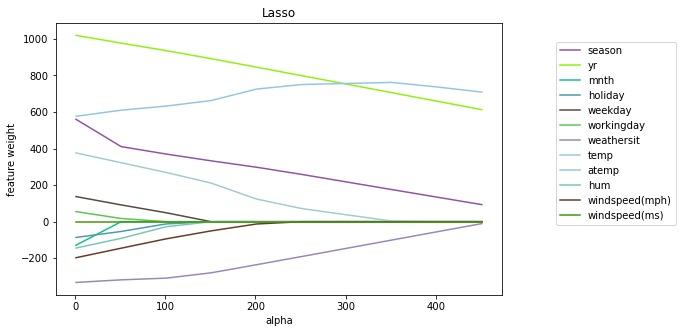

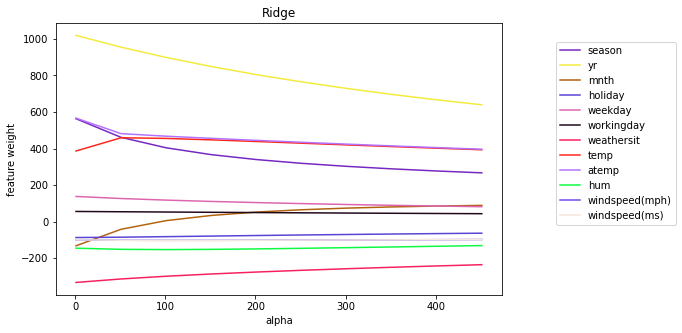

In [216]:
plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

__Block 2. Answer the questions (each 0.25 points)__:
1. Which regularizer (Ridge or Lasso) reduces weights more aggressively for the same alpha?
     * **Answer**: Lasso
1. What happens to the Lasso weights if alpha is made very large? Explain why this happens.
     * **Answer**: All weights will become zero. The regularizer minimizes the sum of the original functional Q and the regularizer with some coefficient alpha , too large alpha will result in a minimum when the weights are zero.
1. Is it possible to state that Lasso excludes one of the features of windspeed for any value of alpha > 0? What about Ridge? It is said that the regularizer excludes a feature if its coefficient < 1e-3.
     * **Answer**: yes, Lasso excludes one of the windspeed features for any value of alpha > 0, while Ridge does not.
1. Which of the regularizers is suitable for selecting non-informative features?
     * **Answer**: Lasso (L1 regularizer)

### Choosing the best alpha

Next, we will work with Lasso.

So, we see that when changing alpha, the model selects feature coefficients differently. We need to choose the best alpha.

To do this, first, we need a quality metric. We will use the optimized functional of the least squares method itself, that is, Mean Square Error, as a metric.

Secondly, you need to understand on what data this metric is to be calculated. You cannot choose alpha based on the MSE value on the training set, because then we will not be able to evaluate how the model will make predictions on new data for it. If we choose one split of the sample into training and test (this is called holdout), then we tune in to specific "new" data, and we can retrain again. Therefore, we will do several sample splits, try different values of alpha on each, and then average the MSE. It is most convenient to do such partitions by cross-validation, that is, divide the sample into K parts, or blocks, and each time take one of them as a test one, and make a training sample from the remaining blocks.

Doing cross-validation for regression in sklearn is quite simple: there is a special regressor for this, __LassoCV__, which takes a list of alpha as input and for each of them calculates the MSE on cross-validation. After training (set parameter cv=3) the regressor will contain the variable __mse\_path\___, a matrix of size len(alpha) x k, k = 3 (number of blocks in cross-validation) containing the MSE values on the test for the respective runs. In addition, the variable alpha\_ will store the selected value of the regularization parameter, and coef\_, traditionally, will store the trained weights corresponding to this alpha_.

Note that the regressor can change the order in which it passes through alphas; for matching with the MSE matrix, it is better to use the alphas_ regressor variable.

In [217]:
from sklearn.linear_model import LassoCV

**Task** Train a LassoCV regressor on all regularization parameters from alpha. Plot the _averaged_ over the MSE rows against alpha.
Output the selected alpha as well as feature-coefficient pairs for the trained vector of coefficients.

MSE matrix: 
 [[863936.50981215 826364.11936907 862993.29751896]
 [860479.31511364 821110.1817776  853075.13780625]
 [857344.83606082 816153.27782428 843628.81286098]
 [854526.7363943  811496.34805693 834654.45357262]
 [852024.62341384 807139.39657173 826152.16399015]
 [849838.18755425 803082.42338526 818122.01934907]
 [847967.16232762 799325.42849761 810564.07404745]
 [846411.31812808 795868.41190876 803478.36741509]
 [845170.45707972 792711.37361871 796864.92788593]
 [844244.40861679 789854.31362747 790723.77601555]
 [843633.02568868 787297.23193504 785058.69560905]
 [843336.18149882 785040.12854141 779861.12465128]
 [843353.76670095 783083.00344659 775139.90236011]
 [843616.44582031 781425.85665058 770886.43550573]
 [843608.19759457 780068.68815337 767109.44006007]
 [844145.56423514 777586.36117475 763800.36416062]
 [845219.34650306 775290.91645251 760967.79203408]
 [846828.77496205 773628.85569644 755626.71475017]
 [848973.80188236 772598.49562777 749620.88682029]
 [851701.88999353

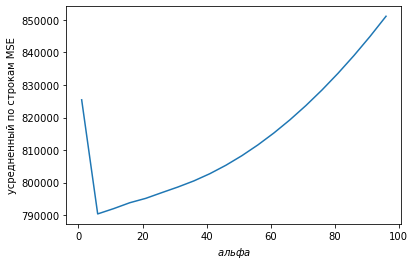

chosen alpha = 6
season 532.02
yr 1015.06
mnth -100.04
holiday -83.29
weekday 132.5
workingday 51.56
weathersit -330.56
temp 370.68
atemp 581.4
hum -140.01
windspeed(mph) -191.77
windspeed(ms) -0.0


In [218]:
alphas = np.arange(1, 100, 5)
cross_val_LCV=linear_model.LassoCV(alphas=alphas, cv=3).fit(X,y)
print ('MSE matrix: \n', cross_val_LCV.mse_path_)
print('\n alphas: \n', cross_val_LCV.alphas_)

#усредненный по строкам MSE:
mean_MSE=[0]*len(alphas)
for i in range(len(alphas)):
    mean_MSE[i]=np.mean(cross_val_LCV.mse_path_[i])
print('\n усредненный по строкам MSE: \n', mean_MSE)

from matplotlib import pylab as plt
plt.plot(cross_val_LCV.alphas_, mean_MSE)
plt.ylabel('усредненный по строкам MSE')
plt.xlabel('$альфа$')
plt.show()


print('chosen alpha =', cross_val_LCV.alpha_)
for i, j in zip(df.columns, cross_val_LCV.coef_.round(2)):
    print(i, j)

So, we have chosen some regularization parameter. Let's see what alpha we would choose if we divided the sample only once into training and test, that is, consider the MSE trajectories corresponding to individual blocks of the sample.

**Task** Print the alpha values corresponding to the MSE minima on each partition (that is, by columns).
 On three separate plots, visualize the .mse_path_ columns

alpha 1 = 41
alpha 2 = 6
alpha 3 = 1


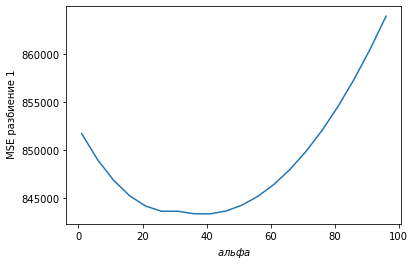

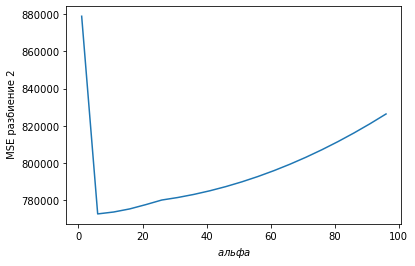

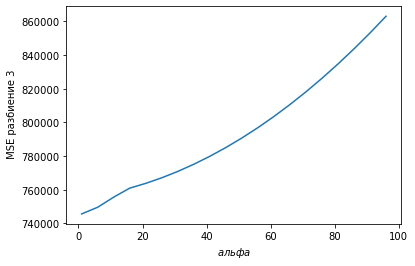

In [219]:
np.amin(cross_val_LCV.mse_path_[:, 0])
for i, e in enumerate(cross_val_LCV.mse_path_[:, 0]):
    if e == np.amin(cross_val_LCV.mse_path_[:, 0]):
        alpha_0=cross_val_LCV.alphas_[i]
        print('alpha 1 =',alpha_0)
for i, e in enumerate(cross_val_LCV.mse_path_[:, 1]):
    if e == np.amin(cross_val_LCV.mse_path_[:, 1]):
        alpha_1=cross_val_LCV.alphas_[i]
        print('alpha 2 =',alpha_1)
for i, e in enumerate(cross_val_LCV.mse_path_[:, 2]):
    if e == np.amin(cross_val_LCV.mse_path_[:, 2]):
        alpha_2=cross_val_LCV.alphas_[i]
        print('alpha 3 =',alpha_2)
        
plt.plot(cross_val_LCV.alphas_, cross_val_LCV.mse_path_[:, 0])
plt.ylabel(' MSE разбиение 1')
plt.xlabel('$альфа$')
plt.show()

plt.plot(cross_val_LCV.alphas_, cross_val_LCV.mse_path_[:, 1])
plt.ylabel(' MSE разбиение 2')
plt.xlabel('$альфа$')
plt.show()

plt.plot(cross_val_LCV.alphas_, cross_val_LCV.mse_path_[:, 2])
plt.ylabel(' MSE разбиение 3')
plt.xlabel('$альфа$')
plt.show()

On each partition, the optimal value of alpha is different, and it corresponds to a large MSE on other partitions. It turns out that we tune in to specific training and control samples. When choosing alpha in cross-validation, we choose something "average" that will give an acceptable metric value at different sample splits.

Finally, let's interpret the result.

__Block 3. Answer the questions (each 0.5 points):__
1. In the last trained model, select 4 features with the highest (positive) coefficients (and write them down), look at the visualizations of cnt dependencies on these features, which we drew in the "Data Acquaintance" block. Is there an increasing linear dependence of cnt on these features in the graphs? Is it logical to say (from common sense) that the greater the value of these features, the more people will want to take bikes?
     * **Answer**: 4 features with the highest (positive) coefficients: season 532.02, yr 1015.06, temp 370.68 and atemp 581.4. The increasing linear dependence of cnt on these features is relatively visible in the graphs. But it is impossible to say 100% that the greater the value of these features, the more people will want to take bicycles. For example, there are only 2 years under consideration in the sample, it is clear that in 2012 more bicycles were taken. But in order to accurately state that over the years people will take more bikes, data for a greater number of years is needed. The second example: the higher the value of the attribute "temperature" to a certain value, the number of rentals will increase, but if the temperature is uncomfortably high, then the rentals will fall.
2. Select 3 features with the largest negative coefficients (and write them down), look at the corresponding visualizations. Is there a decreasing linear relationship? Is it logical to say that the greater the value of these features, the fewer people will want to take bicycles?
     * **Answer**: 3 features with the largest negative coefficients in modulus: weathersit -330.56, hum -140.01, windspeed(mph) -191.77. The decreasing linear dependence is visible and it is logical that the greater the value of these features, the less people will want to take bicycles.
3. Write down features with coefficients close to zero (< 1e-3). Why do you think the model excluded them from the model (look at the graphs again)? Is it true that they have no effect on the demand for bicycles?
     * **Answer**: The model excluded windspeed(ms) -0.0, because it is simply a translation of some units into others, an uninformative feature, linearly dependent on another.

### Conclusion

So, we looked at how you can monitor the adequacy of the linear model, how to select features and how to correctly select the regularization coefficient, if possible without tuning into any particular piece of data.

It should be noted that with the help of cross-validation it is convenient to select only a small number of parameters (1, 2, maximum 3), because for each valid combination of them we have to train the model several times, and this is a time-consuming process, especially if you need to train on large volumes data.